In [97]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import glob
import os
from tqdm import tqdm
import pickle
import numpy as np
import cv2
from PIL import Image
from numpy.random import rand, randint, ranf, randn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
from sklearn.model_selection import train_test_split
import numpy.matlib

%matplotlib inline

# データの読み込み、分割

In [98]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()

,img_name,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,rotation_y
0,004863,Car,0.0,0,-1.55,572.44,181.56,611.95,219.71,1.66,1.73,3.05,-0.82,2.08,33.40,-1.57
1,004863,Tram,0.0,0,-1.48,498.85,149.49,551.40,204.32,3.62,2.60,15.21,-6.27,2.16,55.58,-1.60
2,004863,Car,0.0,1,2.12,56.46,195.89,220.78,260.91,1.47,1.71,4.36,-12.68,2.15,19.71,1.55
3,004863,Car,0.0,0,1.92,321.08,188.65,383.52,221.93,1.52,1.71,3.89,-12.88,2.34,36.20,1.58
4,004863,DontCare,-1.0,-1,-10.00,280.40,183.35,291.90,212.56,-1.00,-1.00,-1.00,-1000.00,-1000.00,-1000.00,-10.00


In [99]:
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.1, shuffle=True, random_state=0)
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 6732 images.
val_list has 749 images.


# 学習データの作成

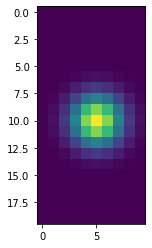

In [100]:
def get_heatmap(h, w, h_center, w_center, sigma=5):
    w_range = np.arange(0,w)-w_center
    w_range = np.matlib.repmat(w_range, h, 1)
    h_range = np.arange(0,h)-h_center
    h_range = h_range.reshape(h,1)
    h_range = np.matlib.repmat(h_range, 1, w)
    Yxyc = np.exp(-(w_range**2+h_range**2)/sigma)
    return Yxyc.T

hm = get_heatmap(10, 20, 5, 10)
plt.imshow(hm)

In [101]:
def line2P(l):
    P_elem = l.split()[1:]
    P = np.array(P_elem, dtype=np.float).reshape(3,-1)
    return P

def readCalib(calib_name, calib_path):
    calib_name = calib_path + calib_name + ".txt"
    with open(calib_name) as f:
        P0 = line2P(f.readline())
        P1 = line2P(f.readline())
        P2 = line2P(f.readline())
        P3 = line2P(f.readline())
        R0_rect = line2P(f.readline())
        Tr_velo_to_cam = line2P(f.readline())
        Tr_imu_to_velo = line2P(f.readline())
    return P0, P1, P2, P3, R0_rect, Tr_velo_to_cam, Tr_imu_to_velo

def projectToImage(pts3D, P):
    P = np.array(P)
    
    ones = np.ones([1,pts3D.shape[1]])
    pts3D = np.append(pts3D, ones, axis=0)
    pts2D = np.dot(P, pts3D)
    pts2D[0] /= pts2D[2]
    pts2D[1] /= pts2D[2]
    pts2D = np.delete(pts2D, obj=2, axis=0)
    return pts2D

def compute3Dbb(obj, P):
    face_idx = np.array([[1,2,6,5], # front face
                         [2,3,7,6], # left face
                         [3,4,8,7], # back face
                         [4,1,5,8]]) # riht face
    ry = obj["rotation_y"]
    R = np.array([[ np.cos(ry), 0, np.sin(ry)],
                  [          0, 1,          0],
                  [-np.sin(ry), 0, np.cos(ry)]],
                 dtype=np.float)
    l = obj["length"]
    w = obj["width"]
    h = obj["height"]
    corners = np.array([[l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2],
                        [0,0,0,0,-h,-h,-h,-h],
                        [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]],
                       dtype=np.float).reshape(3,-1)
    corner3D = np.dot(R,corners)
    xyz = np.array([obj["x"], obj["y"], obj["z"]], dtype=np.float).reshape([3,1])
    corner3D += xyz
    
    # 近すぎる点があるときは計算しない？
    #if any(corner3D[2,:]<0.1):
    #    corner2D = []
    #else:
    #    corner2D = projectToImage(corner3D, P)
    corner2D = projectToImage(corner3D, P)

    return corner2D, face_idx

def getP2(img_name):
    calib_path = "../data/training/calib/"
    _, _, P2, _, _, _, _ = readCalib(img_name, calib_path)
    return P2

def getCorner3D(img_name):
    annotations = annotations_list[annotations_list["img_name"]==img_name]
    _, _, P2, _, _, _, _ = readCalib(img_name, self.calib_path)

    corner3Ds = []
    for _, anno in annotations.iterrows():
        corner3D, face_idx = compute3Dbb(anno, P2)
        corner3Ds.append(corner3D)

    return corner3Ds

In [102]:
RESIZE_SCALE = 4
IMG_WIDTH = 1280 // RESIZE_SCALE
IMG_HEIGHT = IMG_WIDTH // 16 * 5 #400
MODEL_SCALE = 4

def preprocess_image(img):
    #画像サイズを統一
    img_shape = img.shape[0]//RESIZE_SCALE, img.shape[1]//RESIZE_SCALE
    off_x = randint(0, IMG_WIDTH-img_shape[1])
    off_y = randint(0, IMG_HEIGHT-img_shape[0])
    
    img_dummy = np.zeros([IMG_HEIGHT, IMG_WIDTH, 3])
    resize_img = cv2.resize(img, (img_shape[1], img_shape[0]))
    img_dummy[off_y:off_y+img_shape[0], off_x:off_x+img_shape[1]] = resize_img
    return (img_dummy / 255).astype('float32'), (off_x, off_y)

def get_mask_and_regr(img_name, annotations_list, offset=(0,0)):
    
    mask = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    mask_cnr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE], dtype='float32')
    regr_names = ['width', 'height']
    regr = np.zeros([IMG_HEIGHT // MODEL_SCALE, IMG_WIDTH // MODEL_SCALE, 2], dtype='float32')
    
    annotations = annotations_list[annotations_list["img_name"]==img_name]

    P2 = getP2(img_name)
    
    target_type = ['Car', 'Van', 'Truck']
    for _, anno in annotations.iterrows():
        if anno["type"] in target_type:
            ## center pointの学習データを作成 
            # annotationをx, y, width, heightに変換
            x = (anno["left"]+anno["right"])/2 / MODEL_SCALE
            y = (anno["top"]+anno["bottom"])/2 / MODEL_SCALE
            width = (anno["right"]-anno["left"]) / MODEL_SCALE
            height = (anno["bottom"]-anno["top"]) / MODEL_SCALE
            
            x = x / RESIZE_SCALE
            y = y / RESIZE_SCALE
            
            x = np.round(x+offset[0]/ MODEL_SCALE).astype('int')
            y = np.round(y+offset[1]/ MODEL_SCALE).astype('int')
            
            width = width / RESIZE_SCALE
            height = height / RESIZE_SCALE
            
            w = max(width,1)
            h = max(height,1)
            hm = get_heatmap(int(w), int(h), w/2, h/2)
            #print("w:",w, ", h:", h, "hm:", hm.shape)
            left = int(x-w/2)
            top = int(y-h/2)
            #print(top,top+h, left, left+w)
            # x, y, width, heightからmask, regrを作成
            mask[top:top+int(h), left:left+int(w)] = hm
            regr[top:top+int(h), left:left+int(w), 0] = height
            regr[top:top+int(h), left:left+int(w), 1] = width

            ## cornerの学習データを作成
            if w > 5:
                cnr, _ = compute3Dbb(anno, P2)
                cnr[0] = cnr[0]+ offset[1]
                cnr[1] = cnr[1]+ offset[0]
                for i in range(8):
                    try:
                        mask_cnr[int(cnr[1,i]/RESIZE_SCALE/MODEL_SCALE),int(cnr[0,i]/RESIZE_SCALE/MODEL_SCALE)] = 1
                    except:
                        pass
    
    return mask, regr, mask_cnr

original image


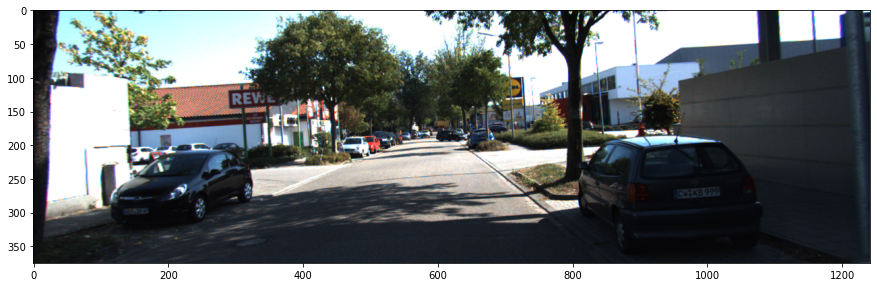

In [103]:
def get_img_path(img_name_list):
    for i in range(len(img_name_list)):
        img_name_list[i] = PATH + "image_2/" + img_name_list[i] + ".png"
        return img_name_list

img_name = train_list[10]
img_name_list = get_img_path([img_name])

print("original image")
img = plt.imread(img_name_list[0])
plt.figure(figsize=(15,8))
plt.imshow(img)

resized image


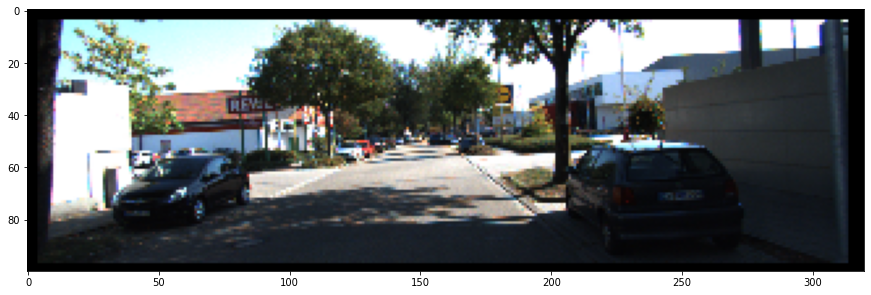

In [104]:
print("resized image")
img, offset = preprocess_image(img)
plt.figure(figsize=(15,8))
plt.imshow(img*255)

vehicle mask
corner mask


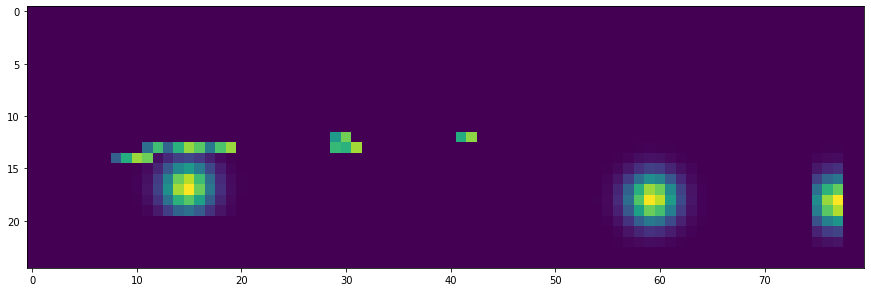

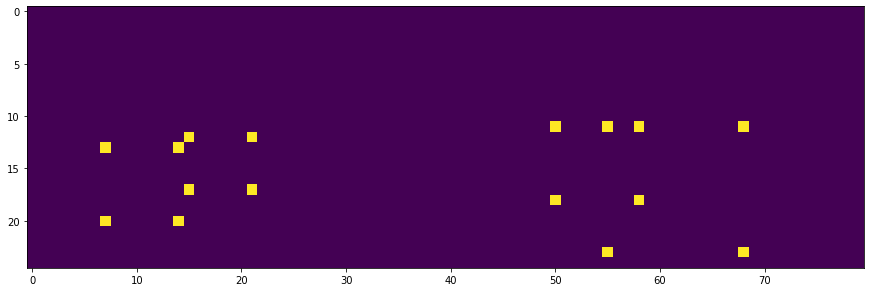

In [105]:
mask, regr, mask_cnr = get_mask_and_regr(img_name, annotations_list, offset)
print("vehicle mask")
plt.figure(figsize=(15,8))
plt.imshow(mask)
print("corner mask")
plt.figure(figsize=(15,8))
plt.imshow(mask_cnr)

# 学習データ生成のためのclassを定義

In [106]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, annotation, root_dir, training=True):
        self.data_list = data_list
        self.anno = annotation
        self.root_dir = root_dir
        self.training = training
        
        self.anno = pd.read_pickle(ANNOTATIONS)
        

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data
        img_name = self.data_list[idx]
        img_path = self.root_dir + "image_2/" + img_name + ".png"
        img = plt.imread(img_path)
        img, offset = preprocess_image(img)
        mask, regr, mask_cnr = get_mask_and_regr(img_name, self.anno, offset)
        
        # Augmentation
        if self.training:
            fliplr = rand()>.5
            if fliplr:
                img, mask, regr, mask_cnr = img[:,::-1], mask[:,::-1], regr[:,::-1], mask_cnr[:,::-1]
            fliptb = rand()>.5
            if fliptb:
                img, mask, regr, mask_cnr = img[::-1], mask[::-1], regr[::-1], mask_cnr[:,::-1]
                
        # 配列の向き？を入れ替える
        img = np.rollaxis(img, 2, 0)
        regr = np.rollaxis(regr, 2, 0)
            
        return [img.copy(), mask.copy(), regr.copy(), mask_cnr.copy()]

In [107]:
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

In [108]:
BATCH_SIZE = 16

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# DL Model

In [109]:
#!pip3 install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [110]:
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2=None):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        
        if x2 is not None:
            x = torch.cat([x2, x1], dim=1)
        else:
            x = x1
        x = self.conv(x)
        return x

def get_mesh(batch_size, shape_x, shape_y):
    mg_x, mg_y = np.meshgrid(np.linspace(0, 1, shape_y), np.linspace(0, 1, shape_x))
    mg_x = np.tile(mg_x[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mg_y = np.tile(mg_y[None, None, :, :], [batch_size, 1, 1, 1]).astype('float32')
    mesh = torch.cat([torch.tensor(mg_x).to(device), torch.tensor(mg_y).to(device)], 1)
    return mesh

In [111]:
class EfficientNet_(EfficientNet):
    
    def extract_features_midconv(self, inputs):
        out = []
        
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks)
            y = block(x, drop_connect_rate=drop_connect_rate)
            if y.size()[-1] != x.size()[-1]:
                out.append(x)
            x = y
            
        x = self._swish(self._bn1(self._conv_head(x)))
        out.append(x)
        
        return out[1:]

In [112]:
class MyUNet(nn.Module):
    '''Mixture of previous classes'''
    def __init__(self, n_classes):
        super(MyUNet, self).__init__()
        self.base_model = EfficientNet_.from_pretrained('efficientnet-b0')
        
        self.mp = nn.MaxPool2d(2)
        
        self.up1 = up(1282 + 112, 256)
        self.up2 = up(256 + 40, 128)
        self.up3 = up(128 + 24, 64)
        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x2, x3, x4, x5 = self.base_model.extract_features_midconv(x)
        
        # Add positional info
        mesh2 = get_mesh(batch_size, x5.shape[2], x5.shape[3])
        x5 = torch.cat([x5, mesh2], 1)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.outc(x)
        return x

In [113]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

n_epochs = 25

## MyUNetの出力ベクトル長を設定
model = MyUNet(4).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 4, gamma=0.1)

cpu
Loaded pretrained weights for efficientnet-b0


# Training

In [114]:
lambda_size = 0.1

def criterion(prediction, mask, regr, mask_cnr, size_average=True):
    # Binary mask loss
    pred_mask = torch.sigmoid(prediction[:, 0])
    # mask_loss = mask * (1 - pred_mask)**2 * torch.log(pred_mask + 1e-12) + (1 - mask) * pred_mask**2 * torch.log(1 - pred_mask + 1e-12)
    mask_loss = mask * torch.log(pred_mask + 1e-12) + (1 - mask) * torch.log(1 - pred_mask + 1e-12)
    mask_loss = -mask_loss.mean(0).sum()
    
    # Regression L1 loss
    pred_regr = prediction[:, 1:3]
    regr_loss = (torch.abs(pred_regr - regr).sum(1) * mask).sum(1).sum(1) / (mask.sum(1).sum(1) + 1)
    regr_loss = regr_loss.mean(0)
    
    # mask_corner _loss
    pred_mask_cnr = torch.sigmoid(prediction[:, 3])
    mask_cnr_loss = mask_cnr * torch.log(pred_mask_cnr + 1e-12) + (1 - mask_cnr) * torch.log(1 - pred_mask_cnr + 1e-12)
    mask_cnr_loss = -mask_cnr_loss.mean(0).sum()
    
    # Sum
    loss = mask_loss + lambda_size*regr_loss + mask_cnr_loss
    if not size_average:
        loss *= prediction.shape[0]
    return loss

In [115]:
FINE_TUNE_EPOCH = 7

def train_model(epoch, history=None):
    model.train()
    
    for batch_idx, (img_batch, mask_batch, regr_batch, cnr_batch) in enumerate(tqdm(train_loader)):
            
        img_batch = img_batch.to(device)
        mask_batch = mask_batch.to(device)
        regr_batch = regr_batch.to(device)
        cnr_batch = cnr_batch.to(device)
        
        optimizer.zero_grad()
        output = model(img_batch)
        loss = criterion(output, mask_batch, regr_batch, cnr_batch)
        if history is not None:
            history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
        
        loss.backward()
        
        optimizer.step()
        exp_lr_scheduler.step()
    
    print('Train Epoch: {} \tLR: {:.6f}\tLoss: {:.6f}'.format(
        epoch,
        optimizer.state_dict()['param_groups'][0]['lr'],
        loss.data))

def evaluate_model(epoch, history=None):
    model.eval()
    loss = 0
    
    with torch.no_grad():
        for img_batch, mask_batch, regr_batch, cnr_batch in val_loader:
            img_batch = img_batch.to(device)
            mask_batch = mask_batch.to(device)
            regr_batch = regr_batch.to(device)
            cnr_batch = cnr_batch.to(device)

            output = model(img_batch)

            loss += criterion(output, mask_batch, regr_batch, cnr_batch, size_average=False).data
    
    loss /= len(val_loader.dataset)
    
    if history is not None:
        history.loc[epoch, 'val_loss'] = loss.cpu().numpy()
    
    print('Val loss: {:.4f}'.format(loss))

In [116]:
import gc

history = pd.DataFrame()

for epoch in range(n_epochs):
    if epoch == 0:
        print("Base model parameters are FREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = False
    elif epoch == FINE_TUNE_EPOCH:
        print("Base model parameters are UNFREEZED.")
        for param in model.base_model.parameters():
            param.requires_grad = True
            
    torch.cuda.empty_cache()
    gc.collect()
    train_model(epoch, history)
    evaluate_model(epoch, history)
    torch.save(model.state_dict(), '../models/model_' + str(epoch) + '.pth')

Base model parameters are FREEZED.

  0%|          | 0/421 [00:00<?, ?it/s]
Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/takeshi/.local/lib/python3.6/site-packages/tqdm/_monitor.py", line 62, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 421/421 [10:16<00:00,  1.46s/it]
Train Epoch: 0 	LR: 0.001000	Loss: 141.151321
Val loss: 246.9169
100%|██████████| 421/421 [09:29<00:00,  1.35s/it]
Train Epoch: 1 	LR: 0.001000	Loss: 146.804962
Val loss: 151.2433
100%|██████████| 421/421 [07:46<00:00,  1.11s/it]
Train Epoch: 2 	LR: 0.001000	Loss: 107.851158
Val loss: 134.2768
100%|██████████| 421/421 [09:26<00:00,  1.35s/it]
Train Epoch: 3 	LR: 0.001000	Loss: 136.601440
Val loss: 129.4903
100%|██████████| 421/421 [08:4

In [117]:
torch.save(model.state_dict(), './model.pth')
model_cpu = model.to('cpu')
torch.save(model_cpu.state_dict(), './model_cpu.pth')

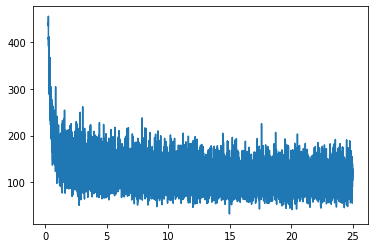

In [118]:
history['train_loss'].iloc[100:].plot()

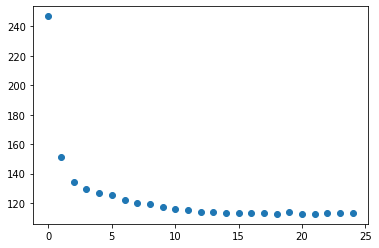

In [119]:
series = history.dropna()['val_loss']
plt.scatter(series.index, series)

In [120]:
m = MyUNet(4)
m.eval()
m_state_dict = torch.load("./model_cpu.pth")
m.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

# Check result

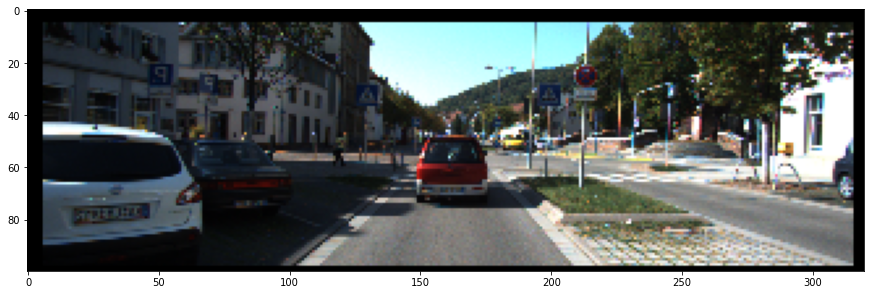

In [125]:
img, mask, regr, cnr = val_dataset[10]
img2 = np.rollaxis(img, 0, 3)
plt.figure(figsize=(15,8))
plt.imshow(img2*255)

In [126]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

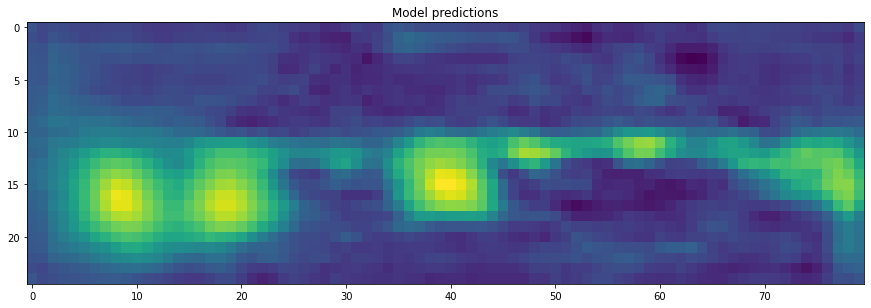

In [127]:
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

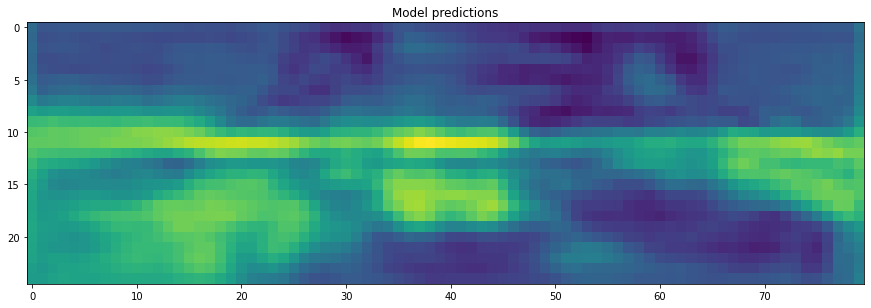

In [128]:
output = m(torch.tensor(img[None]).to(device))
logits = output[0,3].data.cpu().numpy()
plt.figure(figsize=(15,8))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()